In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")

import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import matplotlib
pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Task 1: Basic analysis
Your first task is to perform a basic clean up and summary analysis of the data. Your objective is to summarise the data in a way that simplifies the subsequent tasks. A region by region estimate of the annual millage of different classes of vehicles is a good starting point. Note, the data is missing from much of the minor roads and you should address this is a sensible way.

In [35]:
df = pd.read_csv('dft_traffic_counts_raw_counts.csv')
df.columns

Index(['id', 'count_point_id', 'direction_of_travel', 'year', 'count_date',
       'hour', 'region_id', 'local_authority_id', 'road_name', 'road_category',
       'road_type', 'start_junction_road_name', 'end_junction_road_name',
       'easting', 'northing', 'latitude', 'longitude', 'link_length_km',
       'link_length_miles', 'sequence', 'ramp', 'pedal_cycles',
       'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches',
       'lgvs', 'hgvs_2_rigid_axle', 'hgvs_3_rigid_axle',
       'hgvs_4_or_more_rigid_axle', 'hgvs_3_or_4_articulated_axle',
       'hgvs_5_articulated_axle', 'hgvs_6_articulated_axle', 'all_hgvs',
       'all_motor_vehicles'],
      dtype='object')

In [36]:
df

,id,count_point_id,direction_of_travel,year,count_date,hour,region_id,local_authority_id,road_name,road_category,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,1,931537,S,2003,2003-05-14,15,8,79,C,MCU,...,6.0,34,1.0,0.0,0.0,0.0,0,0.0,1.0,513.0
1,2,931537,S,2003,2003-05-14,16,8,79,C,MCU,...,5.0,68,0.0,1.0,0.0,0.0,0,0.0,1.0,881.0
2,3,931537,S,2003,2003-05-14,17,8,79,C,MCU,...,6.0,81,0.0,0.0,0.0,0.0,0,0.0,0.0,1096.0
3,4,931537,S,2003,2003-05-14,18,8,79,C,MCU,...,1.0,54,1.0,0.0,0.0,0.0,0,0.0,1.0,780.0
4,5,931537,S,2003,2003-05-14,7,8,79,C,MCU,...,1.0,24,1.0,0.0,0.0,0.0,0,0.0,1.0,191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491835,4491836,931537,N,2003,2003-05-14,10,8,79,C,MCU,...,4.0,31,3.0,0.0,0.0,0.0,0,0.0,3.0,282.0
4491836,4491837,931537,N,2003,2003-05-14,11,8,79,C,MCU,...,4.0,25,3.0,0.0,0.0,0.0,0,0.0,3.0,292.0
4491837,4491838,931537,N,2003,2003-05-14,12,8,79,C,MCU,...,3.0,33,4.0,0.0,1.0,0.0,0,0.0,5.0,371.0
4491838,4491839,931537,S,2003,2003-05-14,13,8,79,C,MCU,...,3.0,31,2.0,0.0,0.0,0.0,0,0.0,2.0,419.0


In [37]:
region_id_values = ['1','2','3','4','5','6','7','8','9','10','11']
region_names = ['South West', 'East Midlands', 'Scotland', 'Wales', 'North West', 'London', 'East of England', 'Yorkshire and The Humber', 'South East', 'West Midlands', 'North East']
df['region_name'] = df['region_id'].astype(str).str.strip().replace(dict(zip(region_id_values, region_names)))

df['region_name']

0          Yorkshire and The Humber
1          Yorkshire and The Humber
2          Yorkshire and The Humber
3          Yorkshire and The Humber
4          Yorkshire and The Humber
                     ...           
4491835    Yorkshire and The Humber
4491836    Yorkshire and The Humber
4491837    Yorkshire and The Humber
4491838    Yorkshire and The Humber
4491839    Yorkshire and The Humber
Name: region_name, Length: 4491840, dtype: object

## Number of vehicles annually

In [38]:
no_vehicles = df.pivot_table(
    index = ['year'], 
    values = ['all_motor_vehicles', 'pedal_cycles', 'two_wheeled_motor_vehicles', 
              'cars_and_taxis', 'buses_and_coaches','lgvs', 
              'hgvs_2_rigid_axle', 'hgvs_3_rigid_axle',
              'hgvs_4_or_more_rigid_axle', 'hgvs_3_or_4_articulated_axle',
              'hgvs_5_articulated_axle', 'hgvs_6_articulated_axle', 'all_hgvs'], 
    aggfunc='sum'
)

no_vehicles.groupby('year').mean()
no_vehicles

,all_hgvs,all_motor_vehicles,buses_and_coaches,cars_and_taxis,hgvs_2_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,lgvs,pedal_cycles,two_wheeled_motor_vehicles
year,,,,,,,,,,,,,
2000,10740185.0,129879815.0,1428400.0,100677849.0,4559248.0,987344.0,607021.0,629792.0,2475804,1480976.0,15874559,449098,1158822
2001,10830938.0,138900997.0,1584419.0,107985870.0,4573383.0,916326.0,643813.0,648667.0,2418771,1629978.0,17121975,537224,1377795
2002,10265022.0,133478471.0,1520213.0,104179345.0,4429573.0,811336.0,619816.0,613456.0,2221877,1568964.0,16200579,509905,1313449
2003,9586254.0,131965179.0,1565517.0,103287887.0,4162902.0,704530.0,592740.0,589899.0,2029395,1506797.0,16096236,614112,1429841
2004,9102497.0,124689879.0,1496508.0,97285597.0,3850144.0,648479.0,558653.0,556319.0,1984424,1504481.0,15572605,556938,1233381
2005,8607455.0,118937314.0,1362999.0,92766517.0,3564127.0,564722.0,549147.0,551719.0,1897740,1480038.0,15086367,537812,1115317
2006,9318097.0,126045670.0,1508627.0,97602126.0,3703662.0,586706.0,608427.0,609690.0,2113994,1695620.0,16449287,574948,1168934
2007,9018842.0,125199482.0,1384637.0,96845918.0,3558594.0,533303.0,607200.0,626190.0,1976456,1717128.0,16812618,578313,1138034
2008,8991471.0,135524374.0,1571692.0,105637815.0,3686477.0,481024.0,614203.0,640223.0,1897075,1672469.0,18008139,848041,1315257


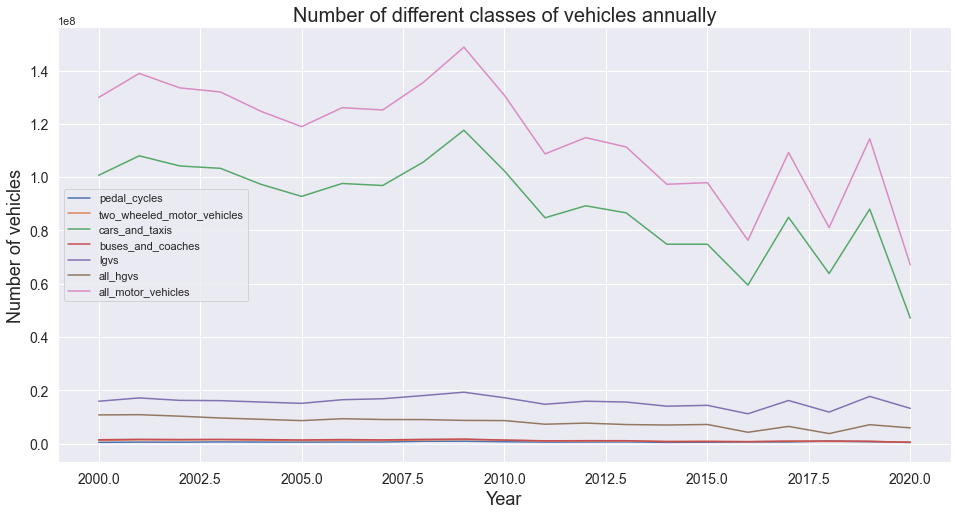

In [39]:
def plot_annual_vehicle_number(vehicle_types):
    plt.plot(no_vehicles[vehicle_types], label = vehicle_types)
    plt.title(f'Number of different classes of vehicles annually', fontsize = 20)
    plt.xlabel('Year', fontsize = 18)
    plt.ylabel('Number of vehicles', fontsize = 18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.legend()

plt.figure(figsize = (16,8))

selected_vehicles = ['pedal_cycles', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'buses_and_coaches', 'lgvs', 'all_hgvs', 'all_motor_vehicles']

for col in selected_vehicles:
    plot_annual_vehicle_number(col)


## Eradicate nan values
Find the columns with the most amount of nan values and proceed to filter them out from the dataframe.

In [40]:
df.isna().sum()

id                                    0
count_point_id                        0
direction_of_travel                   0
year                                  0
count_date                            0
hour                                  0
region_id                             0
local_authority_id                    0
road_name                             0
road_category                         0
road_type                             0
start_junction_road_name        2456628
end_junction_road_name          2456616
easting                               0
northing                              0
latitude                              0
longitude                             0
link_length_km                  2454840
link_length_miles               2454840
sequence                        2454840
ramp                            4012308
pedal_cycles                          0
two_wheeled_motor_vehicles            0
cars_and_taxis                        1
buses_and_coaches                     5


Most of the values in ramp (about 89% of them) are Nan values, therefore it is sensible to drop such a column. The rest of the columns would also be filtered out.

In [41]:
df = df.drop(['ramp'], axis=1)

for col in df.columns:
    df = df[df[f'{col}'].notna()]


## Checking if there is any more nan values in the list to filter

In [42]:
df.isna().sum()

id                              0
count_point_id                  0
direction_of_travel             0
year                            0
count_date                      0
hour                            0
region_id                       0
local_authority_id              0
road_name                       0
road_category                   0
road_type                       0
start_junction_road_name        0
end_junction_road_name          0
easting                         0
northing                        0
latitude                        0
longitude                       0
link_length_km                  0
link_length_miles               0
sequence                        0
pedal_cycles                    0
two_wheeled_motor_vehicles      0
cars_and_taxis                  0
buses_and_coaches               0
lgvs                            0
hgvs_2_rigid_axle               0
hgvs_3_rigid_axle               0
hgvs_4_or_more_rigid_axle       0
hgvs_3_or_4_articulated_axle    0
hgvs_5_articul

## Annual milage by region

In [43]:
region_miles_est = pd.DataFrame()
year_est = pd.DataFrame()
region_year_est = pd.DataFrame()
date_est = pd.DataFrame()

for vehicle in no_vehicles.columns:
    df[f'{vehicle}'] = df[f'{vehicle}'] * df['link_length_miles']
    region_miles_est[f'{vehicle}_milage'] = df.groupby(['region_name'])[f'{vehicle}'].sum()
    year_est[f'{vehicle}_milage'] = df.groupby(['year'])[f'{vehicle}'].sum()
    region_year_est[f'{vehicle}_milage'] = df.groupby(['region_name', 'year'])[f'{vehicle}'].sum()

region_miles_est

,all_hgvs_milage,all_motor_vehicles_milage,buses_and_coaches_milage,cars_and_taxis_milage,hgvs_2_rigid_axle_milage,hgvs_3_or_4_articulated_axle_milage,hgvs_3_rigid_axle_milage,hgvs_4_or_more_rigid_axle_milage,hgvs_5_articulated_axle_milage,hgvs_6_articulated_axle_milage,lgvs_milage,pedal_cycles_milage,two_wheeled_motor_vehicles_milage
region_name,,,,,,,,,,,,,
East Midlands,48240561.99,3.845443e+08,1981252.55,2.793895e+08,14041753.43,3470229.32,2283307.24,2467854.49,13224857.53,12752559.98,5.297451e+07,433900.46,1958439.53
East of England,57915724.94,5.498194e+08,3012072.75,4.056812e+08,18910061.02,3464266.37,2776562.70,3269053.80,14370231.47,15125549.58,7.952437e+07,619884.97,3685984.72
London,14529422.64,2.275270e+08,3522103.05,1.697487e+08,7353001.45,569538.67,969334.24,1638948.13,1714917.08,2283683.07,3.457376e+07,1938759.92,5152982.55
North East,11004902.39,1.507465e+08,1200779.28,1.171089e+08,4015916.98,648437.59,783371.49,920836.15,2141961.57,2494378.61,2.067575e+07,190512.54,756248.34
North West,48174478.74,4.898439e+08,3322352.87,3.723666e+08,16262054.39,2815341.06,2622576.83,2787243.32,10771492.87,12915770.27,6.369509e+07,757135.71,2285423.31
Scotland,15231431.24,1.646062e+08,1919102.66,1.253898e+08,6071169.73,1078383.40,1052234.79,947751.31,2994166.20,3087725.81,2.124003e+07,208905.91,825890.42
South East,70974338.47,9.211788e+08,5455088.57,7.131112e+08,26217963.31,4208608.93,3899262.81,4630075.23,18600462.50,13417965.69,1.245588e+08,1193193.99,7079404.36
South West,32314681.61,4.119097e+08,2840719.04,3.189436e+08,11780513.13,2240302.56,2522040.68,1839193.78,7032192.81,6900438.65,5.476941e+07,623893.50,3041339.26
Wales,15952184.91,2.237016e+08,1992176.44,1.744714e+08,6127390.64,965161.08,1286155.35,1196220.20,3424241.46,2953016.18,3.011450e+07,196156.89,1171381.89


-  A region by region estimate of the annual millage of different classes of vehicles.

In [44]:
year_est

,all_hgvs_milage,all_motor_vehicles_milage,buses_and_coaches_milage,cars_and_taxis_milage,hgvs_2_rigid_axle_milage,hgvs_3_or_4_articulated_axle_milage,hgvs_3_rigid_axle_milage,hgvs_4_or_more_rigid_axle_milage,hgvs_5_articulated_axle_milage,hgvs_6_articulated_axle_milage,lgvs_milage,pedal_cycles_milage,two_wheeled_motor_vehicles_milage
year,,,,,,,,,,,,,
2000,28266118.08,2.716323e+08,2281837.65,2.061121e+08,10854106.07,2765107.41,1472327.07,1473450.62,7340179.83,4360947.08,33127780.73,418041.61,1844494.73
2001,28048912.69,2.807869e+08,2348894.59,2.139074e+08,10571664.16,2555666.25,1517324.83,1470436.56,7163702.89,4770118.00,34379232.16,464208.40,2102517.92
2002,28389292.70,2.921992e+08,2525177.61,2.235416e+08,10952131.44,2402843.31,1599607.37,1495392.50,7002030.80,4937287.28,35532218.39,491013.95,2210896.27
2003,26351675.87,2.699095e+08,2225810.11,2.061144e+08,9988384.14,2106704.19,1472662.02,1370984.67,6557984.00,4854956.85,33142404.94,441395.84,2075239.48
2004,26368325.41,2.709149e+08,2255925.64,2.061348e+08,9783166.59,2009798.53,1476310.72,1393195.43,6654484.47,5051369.67,34260341.63,405451.47,1895439.73
2005,23997943.98,2.540714e+08,2075911.55,1.933433e+08,8815999.31,1668771.72,1386101.25,1323702.83,6104596.02,4698772.85,32816657.17,433261.41,1837590.37
2006,25900577.80,2.707146e+08,2358498.82,2.047786e+08,9144129.27,1725945.73,1530867.03,1448053.71,6726646.67,5324935.39,35752017.00,424304.37,1924908.72
2007,25425136.93,2.670184e+08,2067153.79,2.012731e+08,8772830.93,1601566.22,1513799.92,1493610.21,6481599.35,5561730.30,36424088.46,443154.58,1828950.85
2008,24922315.15,2.657203e+08,1979975.91,2.006441e+08,8647326.73,1427928.72,1483340.82,1513690.08,6323487.24,5526541.56,36195663.56,480374.55,1978189.70


In [45]:
region_year_est

all_hgvs_milage  all_motor_vehicles_milage  \
region_name              year                                               
East Midlands            2000       3345148.70                24394684.90   
                         2001       3399737.74                25581938.85   
                         2002       3427372.42                27170397.17   
                         2003       3125055.74                24884572.56   
                         2004       3205185.50                24863360.58   
...                                        ...                        ...   
Yorkshire and The Humber 2016       1218808.45                11631204.60   
                         2017       1202381.08                12965870.87   
                         2018       1062150.78                10951608.01   
                         2019       1511971.84                13224712.99   
                         2020       1571140.63                 9477843.84   

                               buses_and_coaches_milage  \
region_name              year                             
East Midlands            2000                 142812.23   
                         2001                 149585.78   
                         2002                 164584.96   
                         2003                 139116.62   
                         2004                 148778.14   
...                                                 ...   
Yorkshire and The Humber 2016                  65523.32   
                         2017                  71966.59   
                         2018                  68074.98   
                         2019                  54466.01   
                         2020                  22561.27   

                               cars_and_taxis_milage  \
region_name              year                          
East Midlands            2000            17760639.99   
                         2001            18686681.07   
                         2002            19907163.74   
                         2003            18258600.93   
                         2004            18060790.61   
...                                              ...   
Yorkshire and The Humber 2016             8517950.16   
                         2017             9651492.13   
                         2018             8103524.17   
                         2019             9499141.80   
                         2020             5864870.94   

                               hgvs_2_rigid_axle_milage  \
region_name              year                             
East Midlands            2000                1202289.17   
                         2001                1184602.17   
                         2002                1134518.29   
                         2003                 994330.40   
                         2004                1009283.24   
...                                                 ...   
Yorkshire and The Humber 2016                 282148.52   
                         2017                 283297.06   
                         2018                 257466.02   
                         2019                 380509.74   
                         2020                 316059.15   

                               hgvs_3_or_4_articulated_axle_milage  \
region_name              year                                        
East Midlands            2000                            352762.11   
                         2001                            328723.51   
                         2002                            335523.13   
                         2003                            290721.17   
                         2004                            276511.74   
...                                                            ...   
Yorkshire and The Humber 2016                             59689.72   
                         2017                             62414.10   
                         2018                             45176.

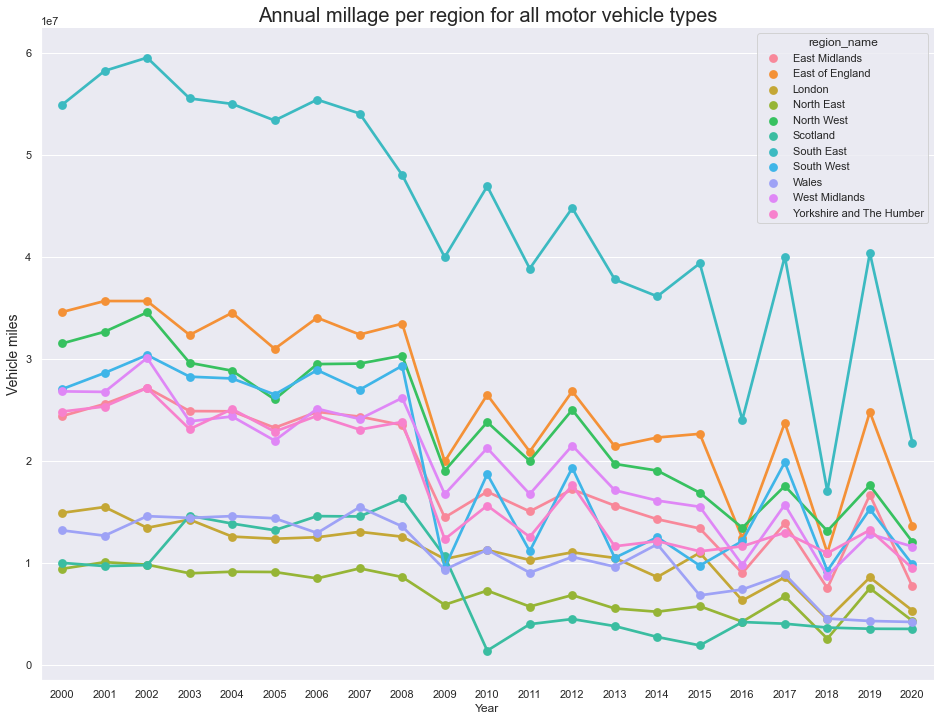

In [46]:
plt.figure(figsize=(16,12))

region_year_est.reset_index(inplace=True)
ax = sns.pointplot(x='year', y='all_motor_vehicles_milage', data=region_year_est, hue="region_name")
plt.xlabel('Year')
plt.ylabel('Vehicle miles', fontsize=14)
plt.title('Annual millage per region for all motor vehicle types', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [68]:
df = pd.read_csv('region_traffic_by_vehicle_type.csv')
df = df[df['year'] >= 2000]
region_id_values = ['1','2','3','4','5','6','7','8','9','10','11']
region_names = ['South West', 'East Midlands', 'Scotland', 'Wales', 'North West', 'London', 'East of England', 'Yorkshire and The Humber', 'South East', 'West Midlands', 'North East']
df['region_name'] = df['region_id'].astype(str).str.strip().replace(dict(zip(region_id_values, region_names)))
df

,id,year,region_id,ons_code,total_link_length_km,total_link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles,region_name
0,1,2015,9,E12000008,47896.8800,29761.74,5.335796e+08,4.938061e+08,44161584807,317222382.3,8045218862,2.450647e+09,55468478734,South East
1,2,2001,7,E12000006,39287.5000,24412.12,3.887977e+08,3.433035e+08,25942676594,296600668.7,3929148042,2.060673e+09,32572402193,East of England
2,3,2018,7,E12000006,40003.1251,24856.79,4.558732e+08,3.282085e+08,30647940894,214265260.8,6476405328,2.206569e+09,39873389085,East of England
3,4,2014,6,E12000007,14842.8400,9222.91,3.757121e+08,4.202652e+08,15782871411,357612058.6,2838823044,6.466761e+08,20046247854,London
5,6,2016,11,E12000001,16285.2300,10119.17,9.537544e+07,6.900824e+07,9969855945,138366838.4,1795423974,4.467728e+08,12419427808,North East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,302,2001,9,E12000008,47399.1800,29452.48,4.511697e+08,5.384095e+08,42507001875,419231435.5,5610989738,2.554838e+09,51630470816,South East
302,303,2014,2,E12000004,31445.2000,19539.14,2.983650e+08,2.199673e+08,20727376249,191591736.6,3864897703,1.836282e+09,26840114845,East Midlands
304,305,2010,6,E12000007,14819.1000,9208.16,3.634037e+08,4.422842e+08,15348108892,377459057.9,2453383816,6.283220e+08,19249557906,London
305,306,2005,10,E12000005,32439.2500,20156.82,2.011046e+08,2.413257e+08,23637561216,318963925.7,3764128632,1.953848e+09,29915827962,West Midlands


In [69]:
df_annual_region_vehicle = df.groupby(['year','region_name']).sum()
df_annual_region_vehicle.drop(['region_id', 'id', 'total_link_length_km', 'total_link_length_miles'], axis=1, inplace=True)
df_annual_region_vehicle.reset_index(inplace=True)

vehicles = ['pedal_cycles','two_wheeled_motor_vehicles','cars_and_taxis','buses_and_coaches','lgvs','all_hgvs','all_motor_vehicles']

for col in vehicles:
    df_annual_region_vehicle[f'{col}'] = df_annual_region_vehicle[f'{col}'] / 1e9

df_annual_region_vehicle

,year,region_name,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles
0,2000,East Midlands,0.209387,0.204839,18.277014,0.202097,2.637438,1.965540,23.286928
1,2000,East of England,0.382818,0.330687,25.563696,0.295678,3.791534,2.065401,32.046996
2,2000,London,0.281822,0.441184,16.459260,0.318921,2.231814,0.696619,20.147798
3,2000,North East,0.089576,0.073554,9.344539,0.191077,1.209167,0.527882,11.346220
4,2000,North West,0.258356,0.244444,26.432372,0.363608,3.415748,2.118728,32.574900
...,...,...,...,...,...,...,...,...,...
226,2020,South East,0.875716,0.380790,33.732428,0.170067,8.123997,2.304594,44.711876
227,2020,South West,0.499565,0.253280,21.096394,0.139604,5.015562,1.337624,27.842465
228,2020,Wales,0.199823,0.136818,11.503709,0.079696,2.907091,0.656408,15.283721
229,2020,West Midlands,0.318682,0.144163,19.871271,0.092461,4.493435,1.940472,26.541801


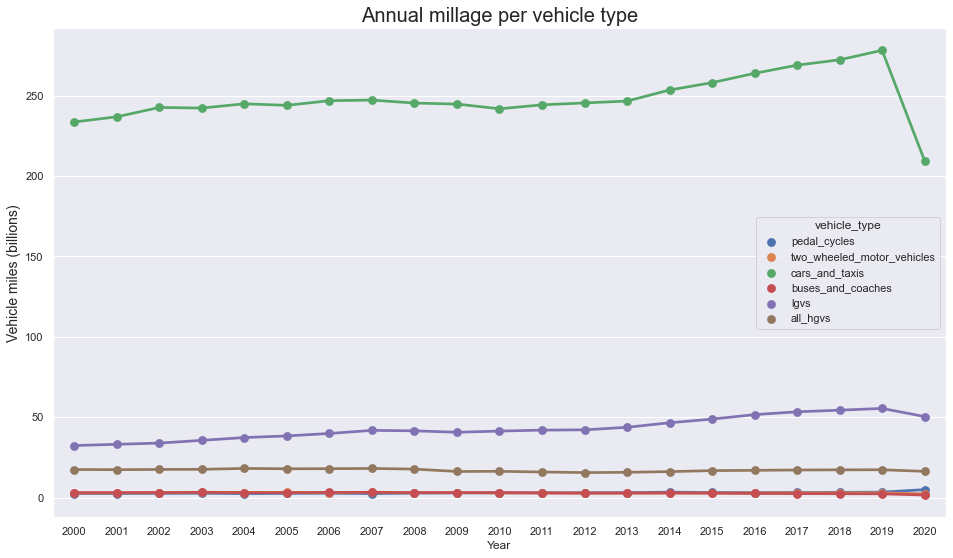

In [70]:
annual_millage_vehicle = df_annual_region_vehicle.groupby(['year']).sum()
annual_millage_vehicle = annual_millage_vehicle.loc[:,annual_millage_vehicle.columns!="all_motor_vehicles"]
annual_millage_vehicle.reset_index(inplace=True)
annual_millage_vehicle = annual_millage_vehicle.rename(columns = {'index':'year'})

df_melted = annual_millage_vehicle.melt("year",var_name="vehicle_type")

plt.figure(figsize=(16,9))
ax = sns.pointplot(x='year', y='value', data=df_melted, hue="vehicle_type")
plt.xlabel('Year')
plt.ylabel('Vehicle miles (billions)', fontsize=14)
plt.title('Annual millage per vehicle type', fontsize=20)
plt.show()

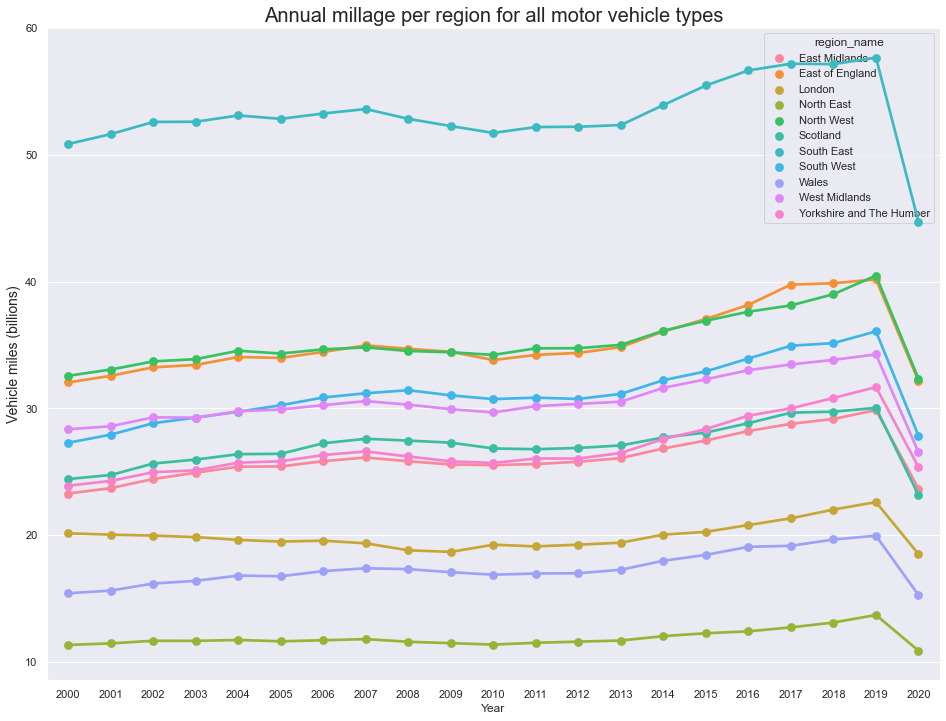

In [71]:
plt.figure(figsize=(16,12))
ax = sns.pointplot(x='year', y='all_motor_vehicles', data=df_annual_region_vehicle, hue="region_name")
plt.xlabel('Year')
plt.ylabel('Vehicle miles (billions)', fontsize=14)
plt.title('Annual millage per region for all motor vehicle types', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

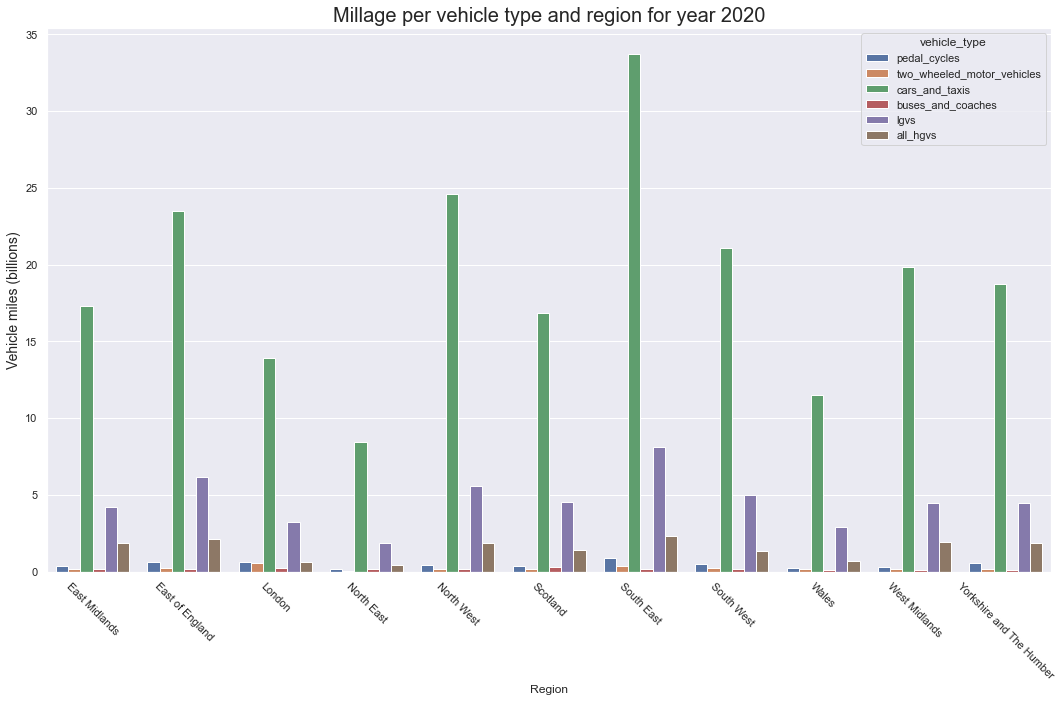

In [72]:
millage_region_vehicle_2020_df = df_annual_region_vehicle.loc[df_annual_region_vehicle['year'] == 2020]
millage_region_vehicle_2020_df = millage_region_vehicle_2020_df.groupby(['region_name']).sum()
millage_region_vehicle_2020_df.reset_index(inplace=True)
millage_region_vehicle_2020_df = millage_region_vehicle_2020_df.loc[:,millage_region_vehicle_2020_df.columns!="all_motor_vehicles"]
millage_region_vehicle_2020_df = millage_region_vehicle_2020_df.loc[:,millage_region_vehicle_2020_df.columns!="year"]

millage_region_vehicle_2020_df = millage_region_vehicle_2020_df.rename(columns = {'index':'region_name'})
df_melted = millage_region_vehicle_2020_df.melt("region_name",var_name="vehicle_type")

plt.figure(figsize=(18,10))
ax = sns.barplot(x='region_name', y='value', data=df_melted, hue="vehicle_type")
plt.xlabel('Region')
plt.ylabel('Vehicle miles (billions)', fontsize=14)
plt.title('Millage per vehicle type and region for year 2020', fontsize=20)
plt.xticks(rotation=-45)
plt.show()

## Annual millage for all motor vehicles

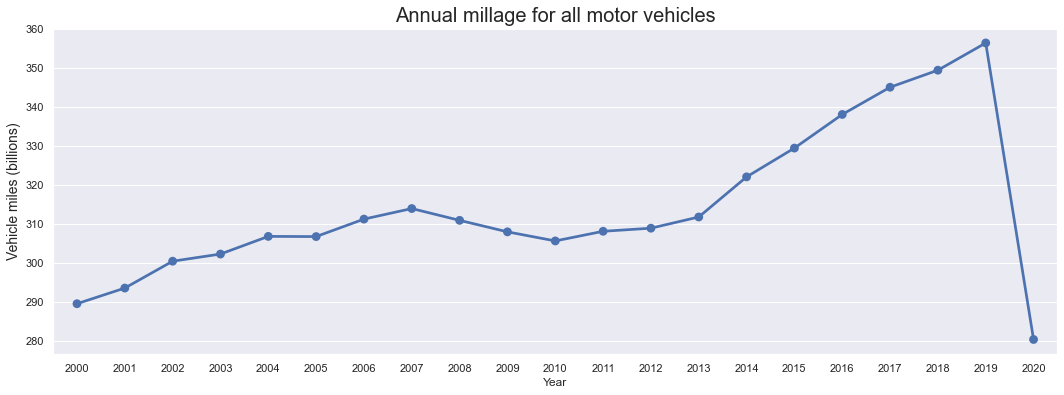

In [73]:
annual_millage_df = df_annual_region_vehicle.groupby(['year']).sum()
annual_millage_df = annual_millage_df.loc[:,annual_millage_df.columns=="all_motor_vehicles"]
annual_millage_df.reset_index(inplace=True)

plt.figure(figsize=(18,6))
ax = sns.pointplot(x='year', y='all_motor_vehicles', data=annual_millage_df)
plt.xlabel('Year')
plt.ylabel('Vehicle miles (billions)', fontsize=14)
plt.title('Annual millage for all motor vehicles', fontsize=20)
plt.show()

# Task 2: Regression
In this task you should use the summary data to perform a regression analysis to estimate likely changes in traffic over the next thirty years. You should identify any potential risks associated with this analysis that may place limits on how it can be used.
# Forecast

<AxesSubplot:xlabel='year'>

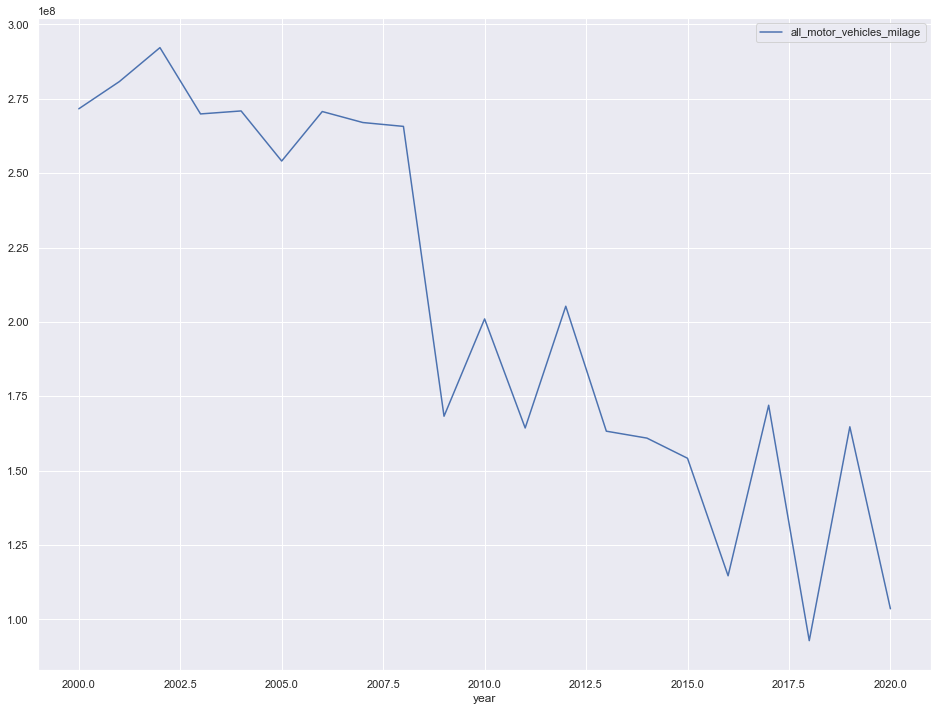

In [53]:
year_est.reset_index().plot(x='year', y='all_motor_vehicles_milage', figsize=(16,12))

By observing the milage of different classes of vehicles, it is predicted that some of these vehicles would eventually not be used around 2030

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


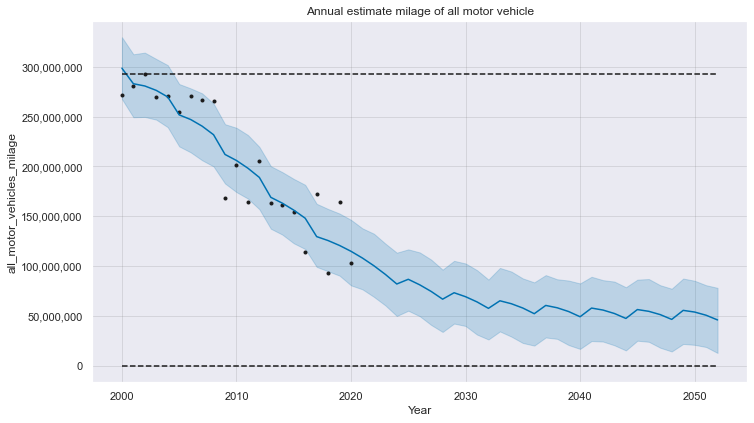

In [54]:
year_est_all_vehicle = pd.DataFrame(year_est)

year_est_all_vehicle['year'] = year_est_all_vehicle.index
year_est_all_vehicle['year'] = pd.to_datetime(year_est_all_vehicle['year'], format='%Y')
year_est_all_vehicle = year_est_all_vehicle.rename(columns={'year':'ds', 'all_motor_vehicles_milage':'y'})
fc = year_est_all_vehicle[['ds', 'y']]
fc['cap'] = fc['y'].max()
fc['floor'] = 0

m = Prophet(growth = 'logistic')
m.fit(fc)
future = m.make_future_dataframe(periods=32, freq ='Y')
future['cap'] = fc['y'].max()
future['floor'] = 0
forecast = m.predict(future)

# Plot
fig = m.plot(forecast)
ax = fig.gca()
ax.set_title('Annual estimate milage of all motor vehicle')
ax.set_ylabel('all_motor_vehicles_milage')
ax.set_xlabel("Year")
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


# Task 3: Research
As your objective is to assess the impact of the expected increase in the number and use of electric vehicles, you will need to research published estimates of how much of the UK vehicle fleet will be electric over time. This is unlikely to be a simple regression using historic data, there will be a number of other factors involved. It is these factors and their impact that you need to identify.
Your goal is to estimate the number of electric miles driven each year over the time period and estimate how much power generation will be needed to achieve this. You will need to identify how much additional generation capacity this will require. You should also attempt to locate at least one other independent estimate of this for comparison to your own estimate.

Assuming that as of 2021, only 2% of the total vehicles in the UK are electic based on this website here:
https://heycar.co.uk/blog/electric-cars-statistics-and-projections
and the number of electric vehicle before 2020 can be consider non-existance

Also, based on this 2018 forecast summary, 97% of the vehicles in 2050 is going to be mostly electric:
https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/873929/road-traffic-forecasts-2018-document.pdf

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/924591/DUKES_2020_MASTER.pdf

https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/840015/DUKES_2019_MASTER_COPY.pdf

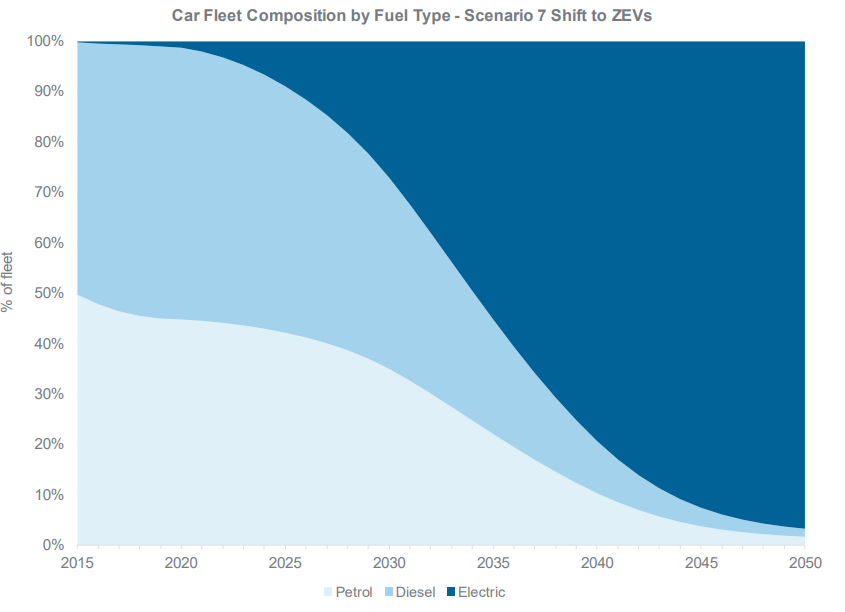

Text(0.5, 0, 'Years')

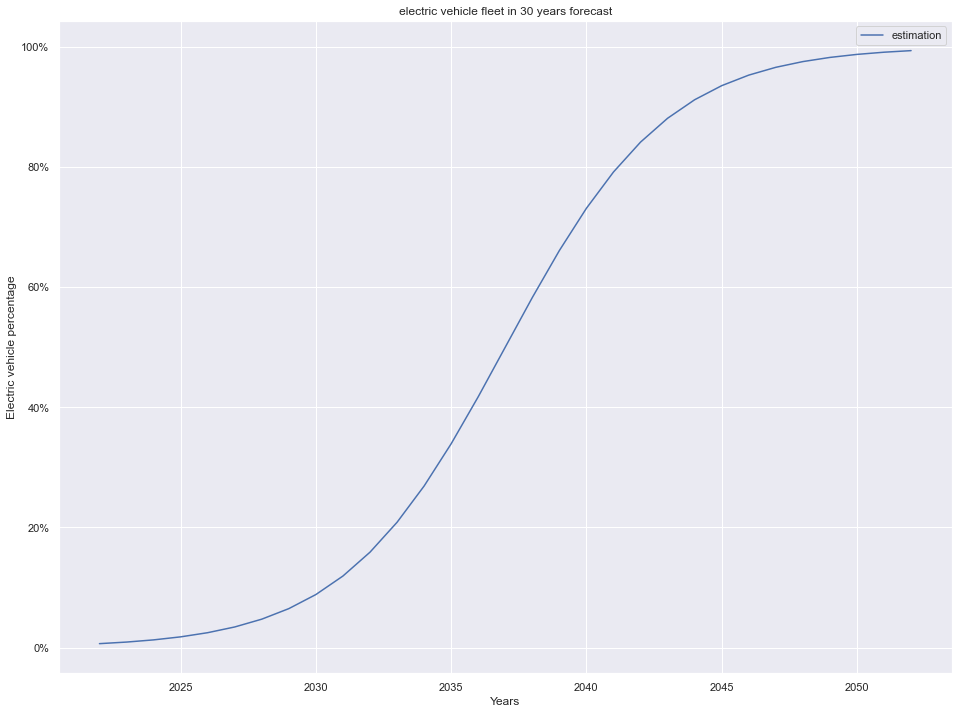

In [55]:
import matplotlib.ticker as mtick

electric_fleet_est = pd.read_csv('electric_vehicle_estimation.csv')
fig = electric_fleet_est.plot(x = 'year', y='estimation', figsize=(16,12))
fig.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
fig.set_title('electric vehicle fleet in 30 years forecast')
fig.set_ylabel('Electric vehicle percentage')
fig.set_xlabel("Years")


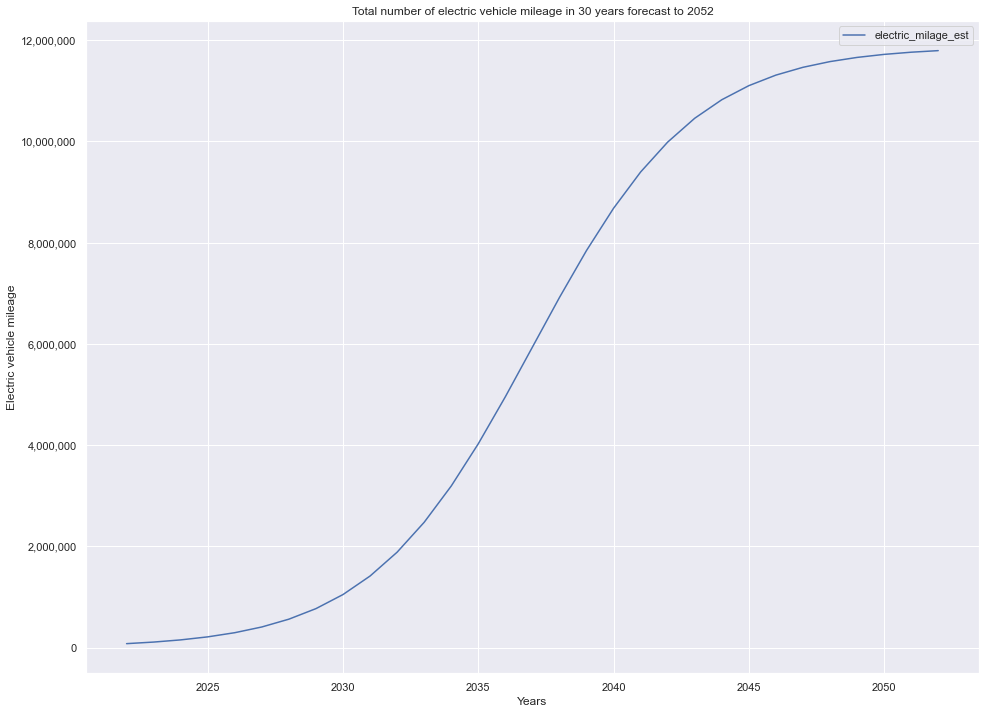

In [56]:
electric_fleet_est['electric_milage_est'] = forecast['trend'][22:].mean() * electric_fleet_est['estimation']
fig = electric_fleet_est.plot(x='year', y='electric_milage_est', figsize=(16,12))
fig.set_title('Total number of electric vehicle mileage in 30 years forecast to 2052')
fig.set_ylabel('Electric vehicle mileage')
fig.set_xlabel('Years')
fig.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


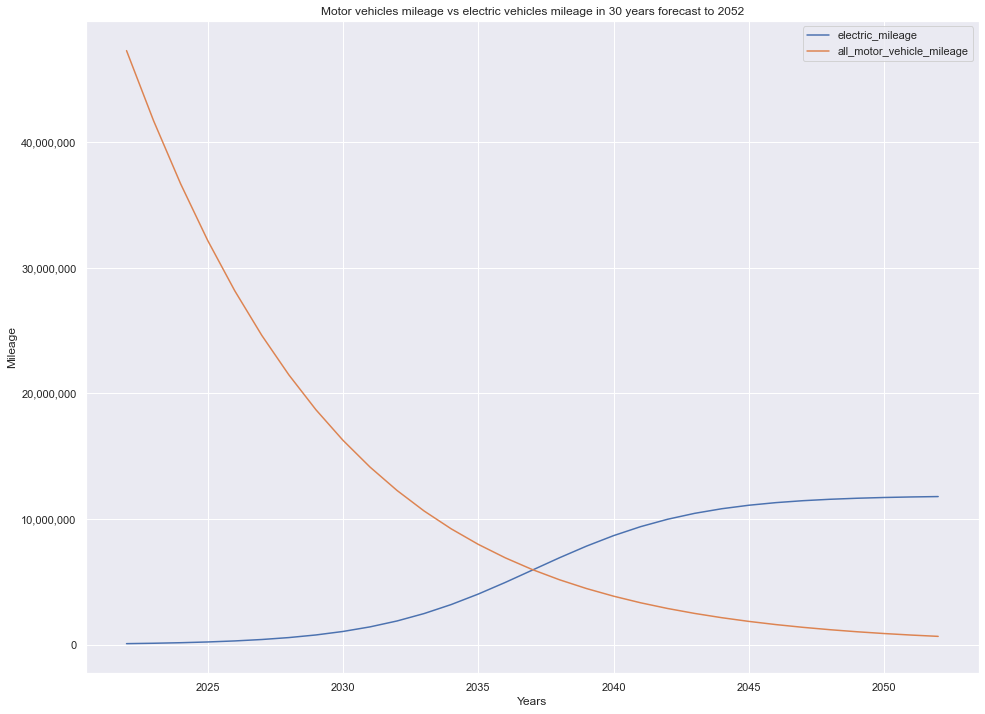

In [57]:
total_v_electric = pd.DataFrame({'electric_mileage': electric_fleet_est['electric_milage_est'] , 'all_motor_vehicle_mileage': forecast['trend'][22:].values, 'year':electric_fleet_est['year']})
fig = total_v_electric.plot(x='year', y=['electric_mileage', 'all_motor_vehicle_mileage'], figsize=(16,12))
fig.set_title('Motor vehicles mileage vs electric vehicles mileage in 30 years forecast to 2052')
fig.set_ylabel('Mileage')
fig.set_xlabel('Years')
fig.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

https://ev-database.uk/cheatsheet/energy-consumption-electric-car

Based on this website, the average energy consumption in the UK is 314 Wh/mi, therefore:

Text(0.5, 0, 'Years')

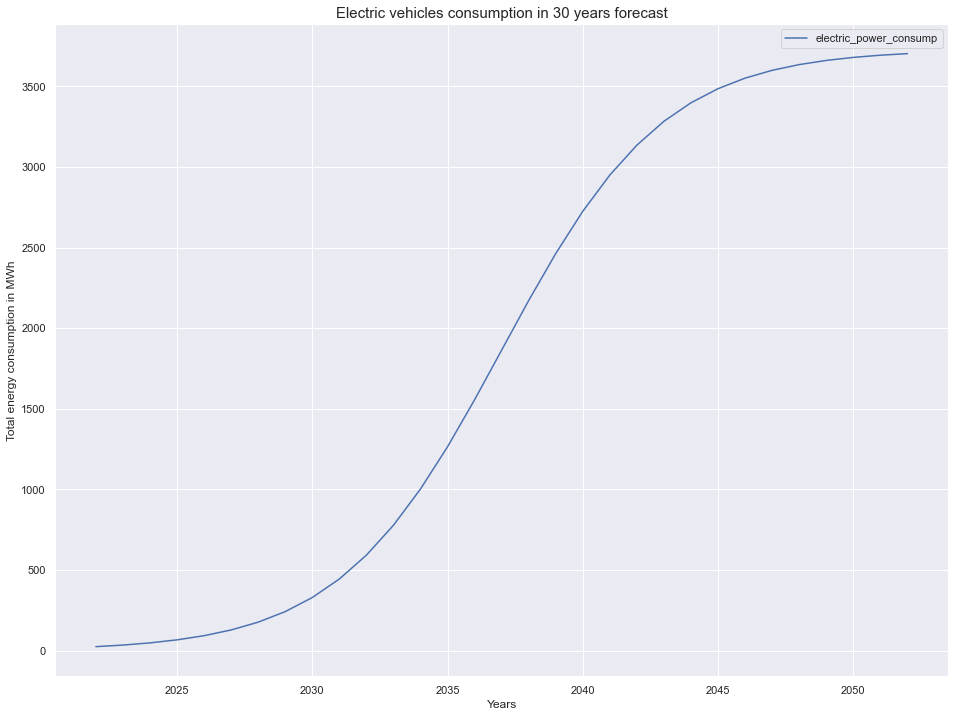

In [58]:
total_v_electric['electric_power_consump'] = total_v_electric['electric_mileage'] * (314/1e6)
fig = total_v_electric.plot(x='year' , y='electric_power_consump' ,figsize=(16,12))
fig.set_title('Electric vehicles consumption in 30 years forecast', size=15)
fig.set_ylabel('Total energy consumption in MWh')
fig.set_xlabel("Years")
# fig.tick_params(axis="x", labelsize=24)
# fig.tick_params(axis="y", labelsize=24)

Generalizing UK's electrical supply, validated from multiple sources https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/904805/DUKES_2020_Chapter_5.pdf it is around 330TWh annually on average

The UK tries to match the production with the demand at around 5TWh. The additional generation capacity that would be needed for the increasing use of these electric vehicles can be found by comparing the demand with this 5TWh surplus that they had over the years. Assuming that this would also continue for the following years. 

Text(0.5, 0, 'Years')

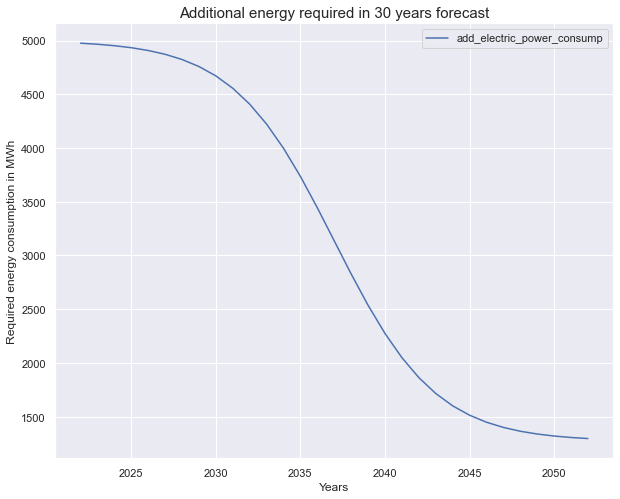

In [59]:
required_energy = 5000
total_v_electric['add_electric_power_consump'] =  required_energy - total_v_electric['electric_power_consump']
fig = total_v_electric.plot(x='year' , y='add_electric_power_consump' ,figsize=(10,8))
fig.set_title('Additional energy required in 30 years forecast', size=15)
fig.set_ylabel('Required energy consumption in MWh')
fig.set_xlabel("Years")

# Task 4: Recommendation
Different generation technologies have different £/MWh figures. The Department for business, energy and strategy (BEIS) maintains a regularly updated overview of generation technologies.
https://www.gov.uk/government/collections/energy-generation-cost-projections
Using this and other sources, you should make a recommendation of the amount and type of new generation capacity that will be needed to meet demand at the lowest overall cost. This is in part an optimisation problem. For example, you might need to take into account the impact that the time of day at which charging occurs will have on the mix of generation technologies that are appropriate.


make a recommendation of the amount and type of new generation capacity that will be needed to meet demand at the lowest overall cost.

take into account the impact that the time of day at which charging occurs will have on the mix of generation technologies that are appropriate.


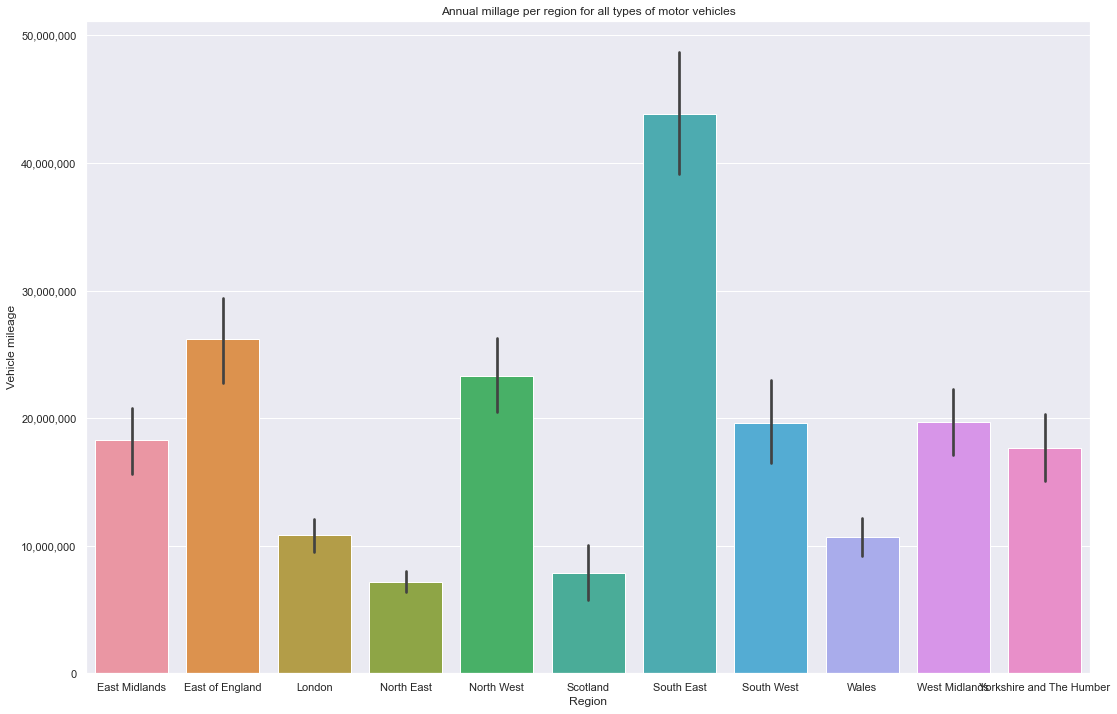

In [60]:
plt.figure(figsize=(18,12))
ax = sns.barplot(x='region_name', y='all_motor_vehicles_milage', data=region_year_est)
plt.xlabel('Region')
plt.ylabel('Vehicle mileage')
plt.title('Annual millage per region for all types of motor vehicles')
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

The additional generation capacity at year 2040 is 103.039

In [61]:
all_avg_millage_region = region_year_est.groupby(['region_name']).mean()
all_avg_millage_region['millage_ratio'] = (all_avg_millage_region['all_motor_vehicles_milage'] / all_avg_millage_region['all_motor_vehicles_milage'].sum())

all_avg_millage_region['additional_power_2040'] = all_avg_millage_region['millage_ratio'] * 103.039 * 1e6
all_avg_millage_region

,year,all_hgvs_milage,all_motor_vehicles_milage,buses_and_coaches_milage,cars_and_taxis_milage,hgvs_2_rigid_axle_milage,hgvs_3_or_4_articulated_axle_milage,hgvs_3_rigid_axle_milage,hgvs_4_or_more_rigid_axle_milage,hgvs_5_articulated_axle_milage,hgvs_6_articulated_axle_milage,lgvs_milage,pedal_cycles_milage,two_wheeled_motor_vehicles_milage,millage_ratio,additional_power_2040
region_name,,,,,,,,,,,,,,,,
East Midlands,2010.0,2.297170e+06,1.831163e+07,94345.359524,1.330426e+07,6.686549e+05,165249.015238,108728.916190,117516.880476,629755.120476,607264.760952,2.522596e+06,20661.926667,93259.025238,0.089266,9.197852e+06
East of England,2010.0,2.757892e+06,2.618187e+07,143432.035714,1.931815e+07,9.004791e+05,164965.065238,132217.271429,155669.228571,684296.736667,720264.265714,3.786875e+06,29518.331905,175523.081905,0.127632,1.315104e+07
London,2010.0,6.918773e+05,1.083462e+07,167719.192857,8.083271e+06,3.501429e+05,27120.889048,46158.773333,78045.149048,81662.718095,108746.812857,1.646369e+06,92321.900952,245380.121429,0.052817,5.442180e+06
North East,2010.0,5.240430e+05,7.178407e+06,57179.965714,5.576612e+06,1.912341e+05,30877.980476,37303.404286,43849.340476,101998.170000,118779.933810,9.845595e+05,9072.025714,36011.825714,0.034993,3.605682e+06
North West,2010.0,2.294023e+06,2.332590e+07,158207.279524,1.773174e+07,7.743835e+05,134063.860000,124884.610952,132725.872381,512928.231905,615036.679524,3.033099e+06,36054.081429,108829.681429,0.113709,1.171650e+07
Scotland,2010.0,7.253062e+05,7.838392e+06,91385.840952,5.970942e+06,2.891033e+05,51351.590476,50106.418571,45131.014762,142579.342857,147034.562381,1.011430e+06,9947.900476,39328.115238,0.038211,3.937190e+06
South East,2010.0,3.379730e+06,4.386566e+07,259766.122381,3.395767e+07,1.248474e+06,200409.949048,185679.181429,220479.772857,885736.309524,638950.747143,5.931371e+06,56818.761429,337114.493333,0.213837,2.203352e+07
South West,2010.0,1.538794e+06,1.961475e+07,135272.335238,1.518779e+07,5.609768e+05,106681.074286,120097.175238,87580.656190,334866.324286,328592.316667,2.608067e+06,29709.214286,144825.679048,0.095618,9.852401e+06
Wales,2010.0,7.596279e+05,1.065246e+07,94865.544762,8.308161e+06,2.917805e+05,45960.051429,61245.492857,56962.866667,163059.117143,140619.818095,1.434024e+06,9340.804286,55780.090000,0.051929,5.350683e+06


https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/911817/electricity-generation-cost-report-2020.pdf

This data was recreated from BEIS Levelised Cost Estimates in electricity generation cost report 2020 (Table 4.17) 

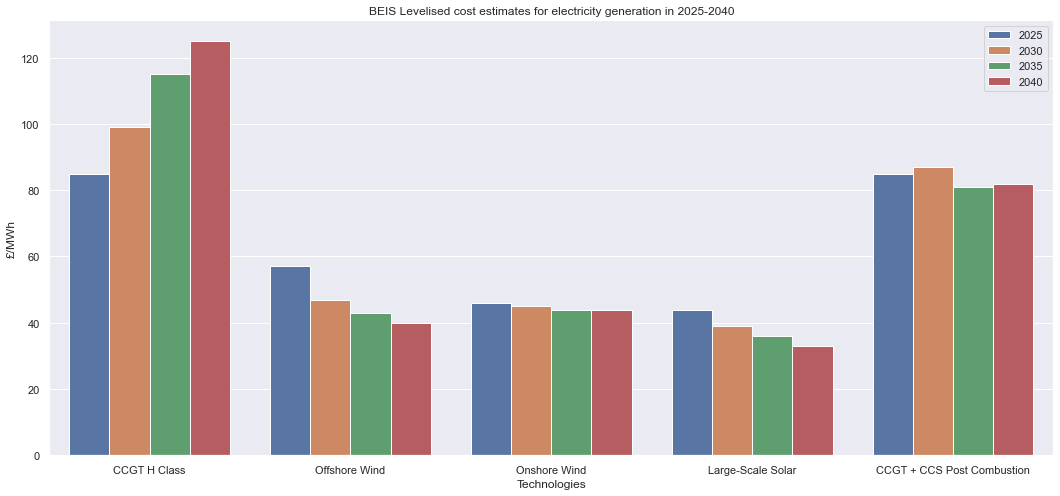

In [62]:
tech_costs = pd.read_csv('BEIS_Levelised_Cost_Estimates_Table4.17.csv')
plt.figure(figsize=(18,8))
ax = sns.barplot(x='technology', y='pound_per_mwh', data=tech_costs, hue="year")
plt.xlabel('Technologies')
plt.ylabel('£/MWh')
plt.title('BEIS Levelised cost estimates for electricity generation in 2025-2040')
plt.legend()
plt.show()

Using BEIS projections for the levelised costs for the electricity generating technologies, the lowest cost estimate is Large-Scale Solar, with Offshore Wind and Onshore Wind coming in 2nd and 3rd lowest respectively. Using mostly Large-Scale solar to cover the additional electricity demand would be my recommendation. If consider other factors such as the location, then every region can choose the most suitable energy generating technology, as it would be near-impossible and ridiculous to build an OffShore Wind farm near the London area.

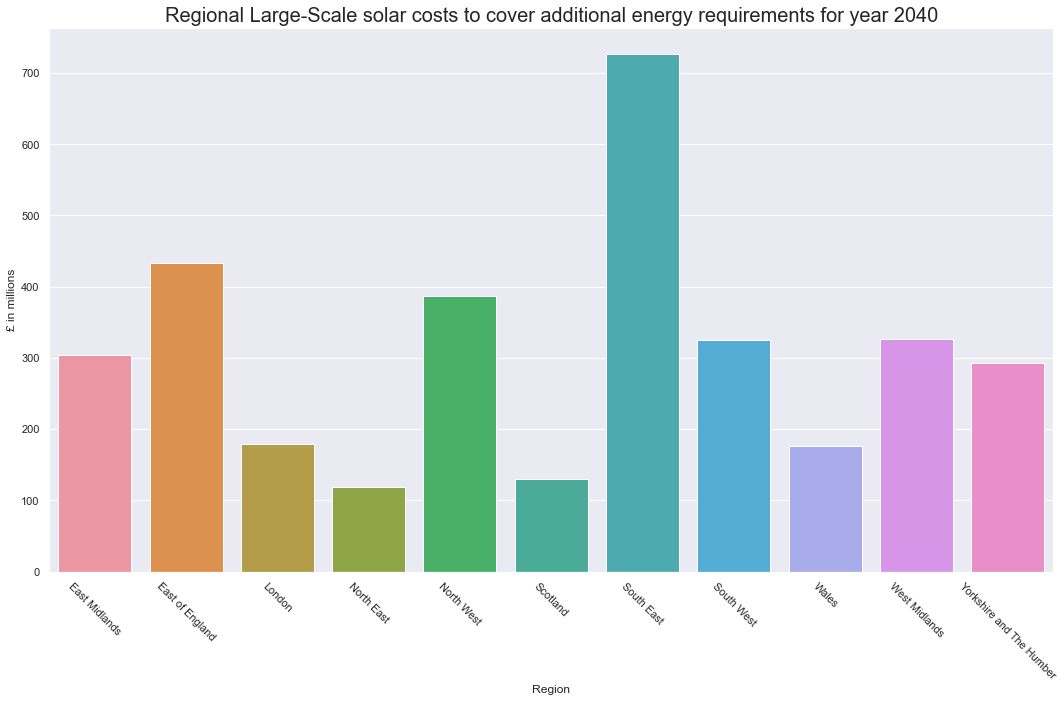

In [63]:
all_avg_millage_region['solar_power_cost_only'] = all_avg_millage_region['additional_power_2040'] * 33 / 1e6

plt.figure(figsize=(18,10))
ax = sns.barplot(x=all_avg_millage_region.index, y='solar_power_cost_only', data=all_avg_millage_region)
plt.xlabel('Region')
plt.xticks(rotation=-45)
plt.ylabel('£ in millions')
plt.title('Regional Large-Scale solar costs to cover additional energy requirements for year 2040', fontsize=20)
plt.show()

## Technology amount
35% OffShore, 25% Onshore, 25% CCGT + CCS, 15% LS Solar

In [64]:
recomendation_costs = all_avg_millage_region[['additional_power_2040']].copy()

recomendation_costs['offshore_wind_costs'] = recomendation_costs['additional_power_2040'] * 40 * 0.35 / 1e6
recomendation_costs['onshore_wind_costs'] = recomendation_costs['additional_power_2040'] * 44 * 0.25 / 1e6
recomendation_costs['CCGT_CCS_costs'] = recomendation_costs['additional_power_2040'] * 33 * 0.25 / 1e6
recomendation_costs['solar_costs'] = recomendation_costs['additional_power_2040'] * 33 * 0.15 / 1e6

recomendation_costs = recomendation_costs.loc[:,recomendation_costs.columns!="additional_power_2040"]
recomendation_costs.reset_index(inplace=True)

recomendation_costs = recomendation_costs.rename(columns = {'index':'region_name'})
df_melted = recomendation_costs.melt("region_name", var_name="tech_cost")

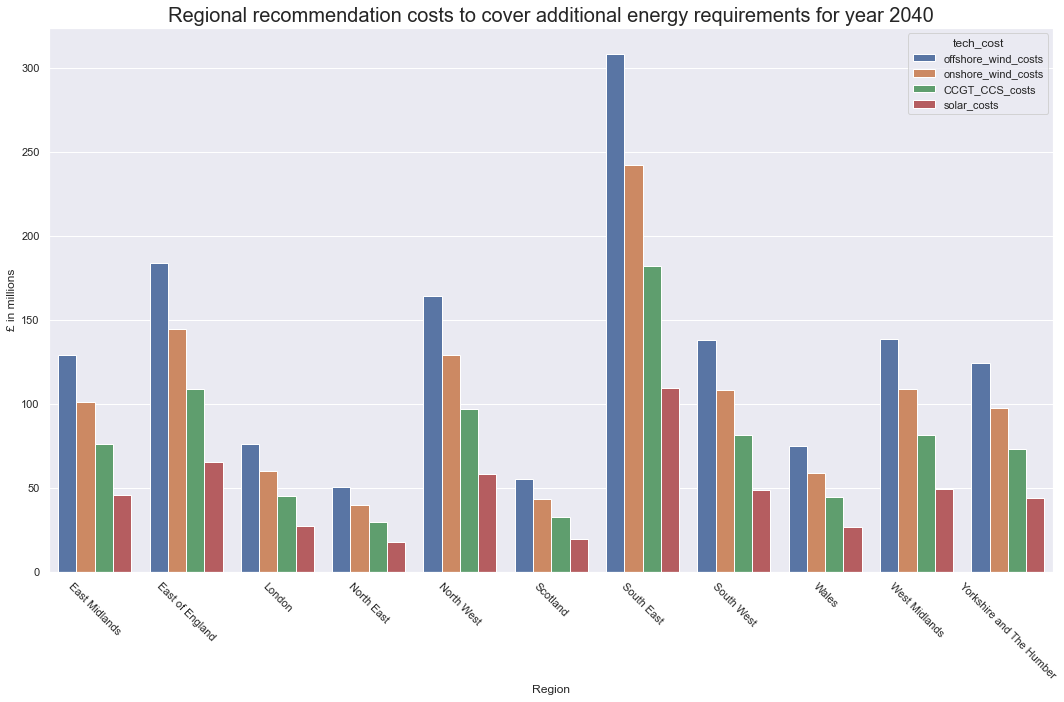

In [65]:
plt.figure(figsize=(18,10))
ax = sns.barplot(x='region_name', y='value', data=df_melted, hue="tech_cost")
plt.xlabel('Region')
plt.ylabel('£ in millions')
plt.title('Regional recommendation costs to cover additional energy requirements for year 2040', fontsize=20)
plt.xticks(rotation=-45)
plt.show()

In [66]:
avg_cost_region = recomendation_costs.groupby('region_name').sum()
avg_cost_region.mean().sum().round()

358.0